# Recommending Restaurants based on User Moods

### Our Product is simple. User has to tell us his/her mood, we'll recommend him/her a restaurant according to the mood. The moods are stress, laziness, happy, depression, sick, cold weather, hunger, etc. The model works well for age range 15-30 due to the dataset.

### About the Dataset
We are using two datasets. First is Zomato Restaurants Dataset and Second is Food Choices of College Students Dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',''])
from nltk.stem import WordNetLemmatizer

ModuleNotFoundError: No module named 'wordcloud'

## Zomato Restaurants Dataset Analysis (in New Delhi)

In [ ]:
res_data = pd.read_csv('zomato.csv', encoding='latin-1')
countryCode_toName = {
    1: "India",
    14: "Australia",
    30: "Brazil",
    37: "Canada",
    94: "Indonesia",
    148: "New Zealand",
    162: "Phillipines",
    166: "Qatar",
    184: "Singapore",
    189: "South Africa",
    191: "Sri Lanka",
    208: "Turkey",
    214: "UAE",
    215: "United Kingdom",
    216: "United States",
}
res_data['Country'] = res_data['Country Code'].apply(lambda x: countryCode_toName[x])

In [ ]:
res_data = res_data.loc[(res_data['Country Code'] == 1) & (res_data['City'] == 'New Delhi'), :]
res_data = res_data.loc[res_data['Longitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] < 29] # clearing out invalid outlier
res_data = res_data.loc[res_data['Rating text'] != 'Not rated']
res_data['Cuisines'] = res_data['Cuisines'].astype(str)
res_data['fusion_num'] = res_data['Cuisines'].apply(lambda x: len(x.split(',')))
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3975 entries, 2561 to 8009
Data columns (total 23 columns):
Restaurant ID           3975 non-null int64
Restaurant Name         3975 non-null object
Country Code            3975 non-null int64
City                    3975 non-null object
Address                 3975 non-null object
Locality                3975 non-null object
Locality Verbose        3975 non-null object
Longitude               3975 non-null float64
Latitude                3975 non-null float64
Cuisines                3975 non-null object
Average Cost for two    3975 non-null int64
Currency                3975 non-null object
Has Table booking       3975 non-null object
Has Online delivery     3975 non-null object
Is delivering now       3975 non-null object
Switch to order menu    3975 non-null object
Price range             3975 non-null int64
Aggregate rating        3975 non-null float64
Rating color            3975 non-null object
Rating text             3975 non-nul

### What are the most famous cuisines in New Delhi?

/home/priyanshrastogi/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



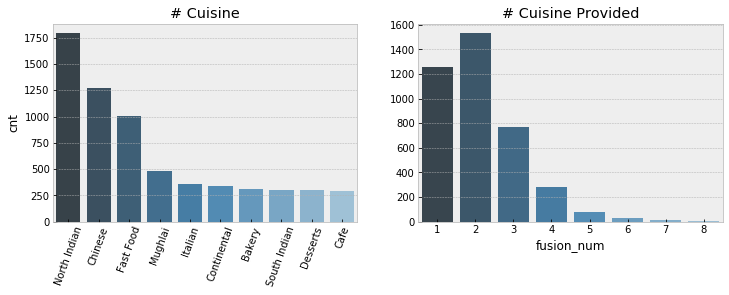

# Unique Cuisine:  78


In [ ]:
lst_cuisine = set()
Cnt_cuisine = Counter()
for cu_lst in res_data['Cuisines']:
    cu_lst = cu_lst.split(',')
    lst_cuisine.update([cu.strip() for cu in cu_lst])
    for cu in cu_lst:
        Cnt_cuisine[cu.strip()] += 1

cnt = pd.DataFrame.from_dict(Cnt_cuisine, orient = 'index')
cnt.sort_values(0, ascending = False, inplace = True)


tmp_cnt = cnt.head(10)
tmp_cnt.rename(columns = {0:'cnt'}, inplace = True)
with plt.style.context('bmh'):
    f = plt.figure(figsize = (12, 8))
    ax = plt.subplot2grid((2,2), (0,0))
    sns.barplot(x = tmp_cnt.index, y = 'cnt', data = tmp_cnt, ax = ax, palette = sns.color_palette('Blues_d', 10))
    ax.set_title('# Cuisine')
    ax.tick_params(axis='x', rotation=70)
    ax = plt.subplot2grid((2,2), (0,1))
    sns.countplot(res_data['fusion_num'], ax=ax, palette = sns.color_palette('Blues_d', res_data.fusion_num.nunique()))
    ax.set_title('# Cuisine Provided')
    ax.set_ylabel('')
    plt.show()        
print('# Unique Cuisine: ', len(lst_cuisine))

### K-Means Clustering - Where are high-rated restaurants located?

In [ ]:
res_data['Rating category'] = res_data['Rating text'].map({'Not rated': -1, 'Poor':0, 'Average':2, 'Good':3, 'Very Good':4, 'Excellent':5})
tmp = res_data['Aggregate rating'].map(np.round)
a = np.full(tmp.shape[0], False, dtype = bool)
((tmp - res_data['Rating category']).map(np.round)).value_counts()
sys_check = res_data[['Aggregate rating', 'Rating category', 'Votes']].copy()
sys_check['distorted'] = (res_data['Aggregate rating'] - res_data['Rating category']).map(np.round)
sys_check['diff'] = sys_check['Aggregate rating'] - sys_check['Rating category']
res_data = res_data.loc[sys_check['distorted'] != 2, :]
res_data['Rating category'] = res_data['Aggregate rating'].round(0).astype(int)

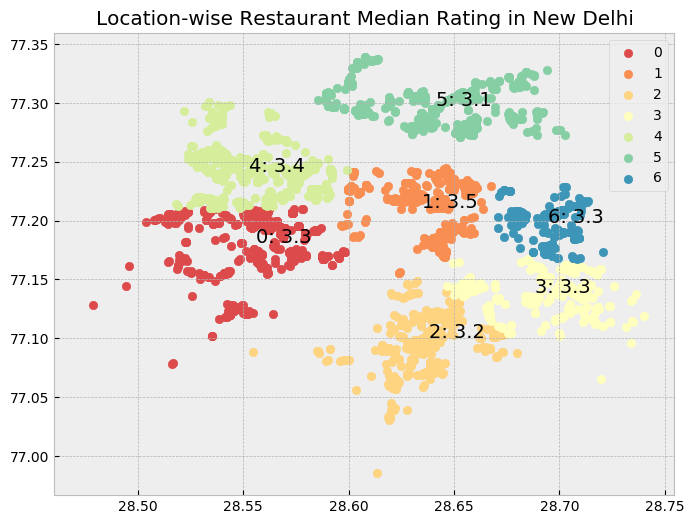

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(res_data[['Longitude', 'Latitude']])
res_data['pos'] = kmeans.labels_
pop_local = res_data.groupby('pos')['Longitude', 'Latitude', 'Aggregate rating'].agg({'Longitude':np.mean, 'Latitude':np.mean, 'Aggregate rating':np.median}).reset_index()

with plt.style.context('bmh', after_reset=True):
    pal = sns.color_palette('Spectral', 7)
    plt.figure(figsize = (8,6))
    for i in range(7):
        ix = res_data.pos == i
        plt.scatter(res_data.loc[ix, 'Latitude'], res_data.loc[ix, 'Longitude'], color = pal[i], label = str(i))
        plt.text(pop_local.loc[i, 'Latitude'], pop_local.loc[i, 'Longitude'], str(i) + ': '+str(pop_local.loc[i, 'Aggregate rating'].round(2)), fontsize = 14, color = 'black')
    plt.title('Location-wise Restaurant Median Rating in New Delhi')
    plt.legend()
    plt.show()

Here we can see that Central Delhi has slight better restaurants than North or South Suburb areas of Delhi.

## Food Choices Dataset Analysis

In [ ]:
food_data = pd.read_csv('food_choices.csv')
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
GPA                             123 non-null object
Gender                          125 non-null int64
breakfast                       125 non-null int64
calories_chicken                125 non-null int64
calories_day                    106 non-null float64
calories_scone                  124 non-null float64
coffee                          125 non-null int64
comfort_food                    124 non-null object
comfort_food_reasons            124 non-null object
comfort_food_reasons_coded      106 non-null float64
cook                            122 non-null float64
comfort_food_reasons_coded.1    125 non-null int64
cuisine                         108 non-null float64
diet_current                    124 non-null object
diet_current_coded              125 non-null int64
drink                           123 non-null float64
eating_changes                  122 non-null object
eating_chan

### What are some comfort food in various situations such as stress, boredom, hunger, happiness?

In [ ]:
food_data[['comfort_food_reasons', 'comfort_food']]

,comfort_food_reasons,comfort_food
0,we dont have comfort,none
1,"Stress, bored, anger","chocolate, chips, ice cream"
2,"stress, sadness","frozen yogurt, pizza, fast food"
3,Boredom,"Pizza, Mac and cheese, ice cream"
4,"Stress, boredom, cravings","Ice cream, chocolate, chips"
5,"None, i don't eat comfort food. I just eat whe...","Candy, brownies and soda."
6,"stress, boredom","Chocolate, ice cream, french fries, pretzels"
7,I eat comfort food when im stressed out from s...,"Ice cream, cheeseburgers, chips."
8,Boredom,"Donuts, ice cream, chips"
9,"Stress, anger and sadness","Mac and cheese, chocolate, and pasta"


In [ ]:
def search_comfort(mood):
    lemmatizer = WordNetLemmatizer()
    foodcount = {}
    for i in range(124):
        temp = [temps.strip().replace('.','').replace(',','').lower() for temps in str(food_data["comfort_food_reasons"][i]).split(' ') if temps.strip() not in stop ]
        if mood in temp:
            foodtemp = [lemmatizer.lemmatize(temps.strip().replace('.','').replace(',','').lower()) for temps in str(food_data["comfort_food"][i]).split(',') if temps.strip() not in stop ]
            for a in foodtemp:
                if a not in foodcount.keys():
                    foodcount[a] = 1 
                else:
                    foodcount[a] += 1
    sorted_food = []
    sorted_food = sorted(foodcount, key=foodcount.get, reverse=True)
    return sorted_food


def find_my_comfort_food(mood):
    topn = []
    topn = search_comfort(mood) #function create dictionary only for particular mood
    print("3 Popular Comfort Foods in %s are:"%(mood))
    print(topn[0])
    print(topn[1])
    print(topn[2])

In [ ]:
find_my_comfort_food('sad')

3 Popular Comfort Foods in sad are:
ice cream
pizza
chip


## Main Part of our Project: Suggesting Restaurants based on User Moods
##### Under Following Moods
* stress
* boredom
* depression/sadness
* hunger
* laziness
* cold weather
* happiness 
* watching tv

### Finding Restaurants based on cuisines

In [ ]:
res_data[res_data.Cuisines.str.contains('pizza', case=False)].sort_values(by='Aggregate rating', ascending=False).head(3)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,Country,fusion_num,Rating category,pos
3658,18400736,Owl is Well,1,New Delhi,"Greater Kailash (GK) 1, New Delhi",Greater Kailash (GK) 1,"Greater Kailash (GK) 1, New Delhi",77.240703,28.541636,"Burger, American, Fast Food, Italian, Pizza",...,No,3,4.5,Dark Green,Excellent,162,India,5,4,4
4665,18419910,Civil House,1,New Delhi,"26, Khan Market, New Delhi",Khan Market,"Khan Market, New Delhi",77.227358,28.600257,"European, Continental, Pizza",...,No,3,4.2,Green,Very Good,113,India,3,4,1
6850,313269,Tossin Pizza,1,New Delhi,"B-6/2, Safdarjung Enclave, Opposite Deer Park,...",Safdarjung,"Safdarjung, New Delhi",77.195728,28.559335,"Pizza, Italian",...,No,2,4.1,Green,Very Good,647,India,2,4,0
